In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# 파일 호출
data_path: str = "data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:02<00:00, 37.37it/s]


In [ ]:
print(df.columns)

In [4]:
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    'hourly_network-data_hashrate_hashrate': "hashrate_value",
    'hourly_network-data_transactions-count_transactions_count_total': 'transaction_count',
    'hourly_network-data_velocity_velocity_supply_total': 'velocity_count'
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 22)

In [ ]:
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)


In [5]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)

df['buy_volume_ma_3h'] = df['buy_volume'].rolling(window=3).mean()
df['buy_volume_std_3h'] = df['buy_volume'].rolling(window=3).std()

df['funding_rates_ma_3h'] = df['funding_rates'].rolling(window=3).mean()
df['funding_rates_std_3h'] = df['funding_rates'].rolling(window=3).std()

df['price_close_pct_change_1h'] = 100*(df['coinbase_premium_gap']-df['coinbase_premium_gap'].shift(1))/(df['coinbase_premium_gap'].shift(1)+100)
df['price_close_pct_change_3h'] = 100*(df['coinbase_premium_gap']-df['coinbase_premium_gap'].shift(3))/(df['coinbase_premium_gap'].shift(3)+100)

df['buy_volume_pct_change_1h'] = 100*(df['buy_volume']-df['buy_volume'].shift(1))/(df['buy_volume'].shift(1)+1)
df['buy_volume_pct_change_3h'] = 100*(df['buy_volume']-df['buy_volume'].shift(3))/(df['buy_volume'].shift(3)+1)

df['liquidation_diff_pct_change_3h'] = 100*(df['liquidation_diff']-df['liquidation_diff'].shift(3))/(df['liquidation_diff'].shift(3)+1)

# df['buy_sell_ratio_pct_change_3h'] = df['buy_sell_ratio'].pct_change(periods=3)
df['is_buy_dominant'] = (df['buy_sell_ratio'] > 1.0).astype(int)
df['volume_diff_pct_change_12h'] = df['volume_diff'].pct_change(periods=12)
df['volume_diff_pct_change_6h'] = df['volume_diff'].pct_change(periods=6)
df['volume_diff_pct_change_additive']=df['volume_diff_pct_change_6h']+df['volume_diff_pct_change_12h'] # star
df['mean_7days'] = df['volume_diff'].rolling(window=168).mean()  # 7 days if hourly data
df['mean_1day'] = df['volume_diff'].rolling(window=24).mean()    # 1 day if hourly data
df['slope_7days'] = df['mean_7days'].diff()
df['slope_1day'] = df['mean_1day'].diff()
df['slope_change']=df['slope_7days']-df['slope_1day'] # star
df.drop(columns=['mean_7days', 'mean_1day','volume_diff_pct_change_12h','volume_diff_pct_change_6h'], inplace=True)



# df['volume_diff_pct_change_12h'] = df['volume_diff'].pct_change(periods=12)
# df['volume_diff_pct_change_6h'] = df['volume_diff'].pct_change(periods=6)
# df['volume_diff_pct_change_additive']=df['volume_diff_pct_change_6h']+df['volume_diff_pct_change_12h'] # star
# df['mean_7days'] = df['volume_diff'].rolling(window=168).mean()  # 7 days if hourly data
# df['mean_1day'] = df['volume_diff'].rolling(window=24).mean()    # 1 day if hourly data
# df['slope_7days'] = df['mean_7days'].diff()
# df['slope_1day'] = df['mean_1day'].diff()
# df['slope_change']=df['slope_7days']-df['slope_1day'] # star
# df.drop(columns=['mean_7days', 'mean_1day'], inplace=True)

# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio", "liquidation_diff", "liquidation_usd_diff", "volume_diff",
    "buy_volume_ma_3h", "buy_volume_std_3h", "funding_rates_ma_3h", "funding_rates_std_3h",
    "price_close_pct_change_1h", "price_close_pct_change_3h", "buy_volume_pct_change_1h", "buy_volume_pct_change_3h",
    "liquidation_diff_pct_change_3h", "is_buy_dominant"
]

/var/folders/zk/056hcq1553j8j8d2gphz8ckm0000gn/T/ipykernel_48310/3295660156.py:28: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['volume_diff_pct_change_12h'] = df['volume_diff'].pct_change(periods=12)
/var/folders/zk/056hcq1553j8j8d2gphz8ckm0000gn/T/ipykernel_48310/3295660156.py:29: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['volume_diff_pct_change_6h'] = df['volume_diff'].pct_change(periods=6)


In [6]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [7]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [8]:
df.groupby('target')['volume_diff_pct_change_additive'].mean()

target
0.0   -71.804221
1.0    -6.323992
2.0     7.768815
3.0    20.792140
Name: volume_diff_pct_change_additive, dtype: float64

In [9]:
train_df.columns

Index(['ID', 'target', 'coinbase_premium_gap', 'coinbase_premium_index',
       'funding_rates', 'long_liquidations', 'long_liquidations_usd',
       'short_liquidations', 'short_liquidations_usd', 'open_interest',
       ...
       'is_buy_dominant_14', 'is_buy_dominant_15', 'is_buy_dominant_16',
       'is_buy_dominant_17', 'is_buy_dominant_18', 'is_buy_dominant_19',
       'is_buy_dominant_20', 'is_buy_dominant_21', 'is_buy_dominant_22',
       'is_buy_dominant_23'],
      dtype='object', length=801)

In [ ]:
def window_slicing(df: pd.DataFrame, window_size: int, step_size: int) -> pd.DataFrame:
    sliced_data = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_df = df.iloc[start:end].copy()
        # window_df['window_start_index'] = start
        sliced_data.append(window_df)
    
    sliced_data_df = pd.concat(sliced_data, axis=0).reset_index(drop=True)
    return sliced_data_df

window_size = 24
step_size = 12

train_0_3 = train_df[train_df['target'].isin([0, 3])]
train_1_2 = train_df[~train_df['target'].isin([0, 3])]

augm_0_3 = window_slicing(train_0_3, window_size=window_size, step_size=step_size)

#train_df_aug_window = pd.concat([train_1_2, augm_0_3], axis=0)

In [ ]:
def noise_injection(df: pd.DataFrame, noise_level: float = 0.01, decay: float = 0.99, seed:int = 42) -> pd.DataFrame:
    np.random.seed(seed)
    df_noisy = df.copy()
    time_steps = np.arange(len(df_noisy))
    for col in df_noisy.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level*df_noisy[col].std(), size=df_noisy[col].shape)
        decays = decay ** time_steps
        df_noisy[col] = df_noisy[col] + noise * decays
    
    return df_noisy    

#train03 = train_df[train_df['target'].isin([0, 3])]

df_noisy = noise_injection(augm_0_3.drop(columns=['target', 'ID']))
df_noisy = df_noisy.reset_index(drop=True)
augm03 = augm_0_3.reset_index(drop=True) 
df_noisy['target'] = augm03['target'].values
df_noisy['ID'] = augm03['ID'].values

train_df_augm = pd.concat([train_1_2, df_noisy], axis=0)


In [ ]:
print(len(df_noisy))  # df_noisy의 길이 확인
# print(len(train03)) 

In [10]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 1,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196937
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 799
[LightGBM] [Info] Start training from score -2.472992
[LightGBM] [Info] Start training from score -0.894135
[LightGBM] [Info] Start training from score -0.873416
[LightGBM] [Info] Start training from score -2.417056
acc: 0.4309360730593607, auroc: 0.615584686881935


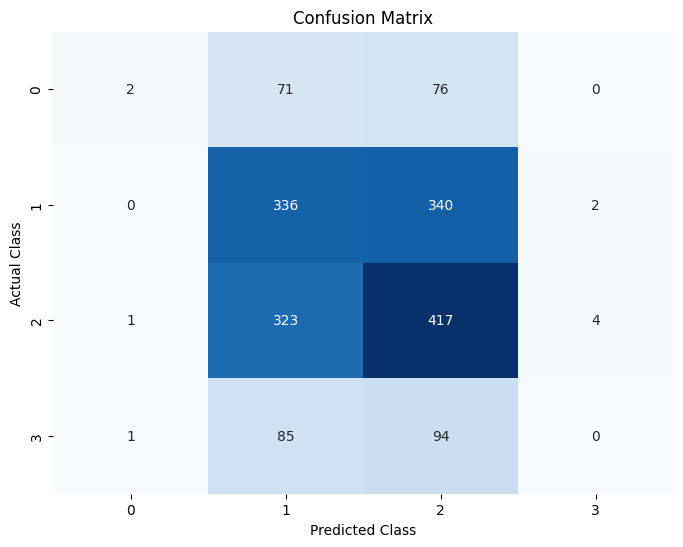

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)
conf_matrix = confusion_matrix(y_valid, y_valid_pred_class)

 # Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()


In [ ]:
#print(train_df_augm)

In [ ]:
importance = lgb_model.feature_importance()
feature_names=train_df.drop(["target", "ID"], axis = 1).columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort by importance (optional)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(feature_importance_df[:30])

In [ ]:
target_ratio_total = train_df_augm["target"].value_counts(normalize=True)

target_ratio_train = y_train.value_counts(normalize=True)

target_ratio_valid = y_valid.value_counts(normalize=True)

print("total data target", target_ratio_total)
print("train data target", target_ratio_train)
print("valid data target", target_ratio_valid)

In [ ]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df_augm.drop(["target", "ID"], axis = 1)
y_train = train_df_augm["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

In [ ]:
# lgb predict
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [ ]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("nathan2.csv", index=False)

window slicing -> acc: 0.47735021919142717, auroc: 0.7850269840520915

window slicing + noise injection acc: 0.5232853513971211, auroc: 0.8128695283409264

window slicing 후 noise injection acc: 0.5428082191780822, auroc: 0.8135914100882286
                                
                                0.5801266439357039, auroc: 0.8530677400461201


# 24시간 기준으로 시간 정보 추가
# 요일 정보 추가 (7일로 나눠서)
# 주말 여부 추가 (토요일(5), 일요일(6)을 주말로 간주)

# 이전 윈도우와의 차이 계산
-> 거래량 
가격 변동등